In [29]:
%load_ext autoreload
%autoreload 2
%aimport

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table

from relaxed import halo_parameters, halo_catalogs 
from relaxed.halo_parameters import get_hparam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [20]:
plt.rc('text', usetex=True)

In [21]:
%matplotlib inline

# Plot style

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('seaborn-colorblind')

In [23]:
mpl.rcParams.update(
{
    # figure
    'figure.figsize':   (10, 10),
    
    # axes
    'axes.labelsize': 24,
    
    # ticks
    'xtick.major.size':  5,
    'xtick.minor.size':  2.5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'xtick.labelsize':   20,
    
    'ytick.major.size':  5,
    'ytick.minor.size':  2.5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.6,
    'ytick.labelsize':   20,
    
    #legend
    'legend.fontsize': 24,

})

In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load catalog

In [7]:
# load catalog we know and love
fpath = Path('/home/imendoza/nbody-relaxed/data/Bolshoi/minh/hlist_1.00035.minh')
name = 'Bolshoi'

# this command just sets up the attributes and filters. Catalog is loaded in the next cell from the *.minh file.
hcat = halo_catalogs.HaloCatalog(name, fpath)

In [8]:
hcat.load_cat_minh()

In [9]:
# Load catalog from minh and apply default filters on-the-fly.  
print('rows in catalog: ', len(hcat.cat))

rows in catalog:  337438


# Add f_sub

In [11]:
from relaxed.subhaloes.catalog import create_subhalo_cat

In [12]:
subhalo_cat = create_subhalo_cat(np.array(hcat.cat['id']), fpath)

In [13]:
# add column to original catalog
assert np.all(subhalo_cat['id'] == hcat.cat['id'])
hcat.cat.add_column(subhalo_cat['f_sub'], name='f_sub')

# Different samples

In [25]:
from relaxed.halo_filters import HaloFilter, get_bound_filter, get_relaxed_filters

In [26]:
# use halo_filters to create additional halo_catalogs for analysis. 
hcat_m11 = HaloFilter(get_bound_filter('mvir', high=11.22, modifier=np.log10), 'M11')(hcat)
hcat_m12 = HaloFilter(get_bound_filter('mvir', 12,12.2, modifier=np.log10), 'M12')(hcat)
hcat_m13 = HaloFilter(get_bound_filter('mvir',13,14,modifier=np.log10), 'M13')(hcat)

power_cat = HaloFilter(get_relaxed_filters('power2011'), 'power2011')(hcat)
neto_cat = HaloFilter(get_relaxed_filters('neto2007'), 'neto2007')(hcat)


# for easy of access
dcats = {
    'm11': hcat_m11,
    'm12': hcat_m12,
    'm13': hcat_m13, 
    
    'power': power_cat,
    'neto': neto_cat,    
    'all': hcat,
}
    

In [27]:
# make sure length of catalogs make sense
print(len(hcat))

print(len(hcat_m11), len(hcat_m12), len(hcat_m13))

# 500 haloes are so > 13.75 
print(len(power_cat), len(neto_cat))

337438
56076 19726 5507
213058 263039


# Histograms

In [33]:
def get_bins(values, n_bins=30): 
    return np.histogram(values, bins=n_bins)[1]

def draw_histogram(ax, values, n_bins=30, bins=None, vline='median', legend_label='', color='r'):
    ax.hist(
        values,
        bins=bins if bins is not None else n_bins,
        histtype='step',
        label=legend_label,
        color=color
    )

    # add a vertical line.
    if vline == "median":
        ax.axvline(np.median(values), ls="--", color=color)



## Histogram of Mvir for different samples

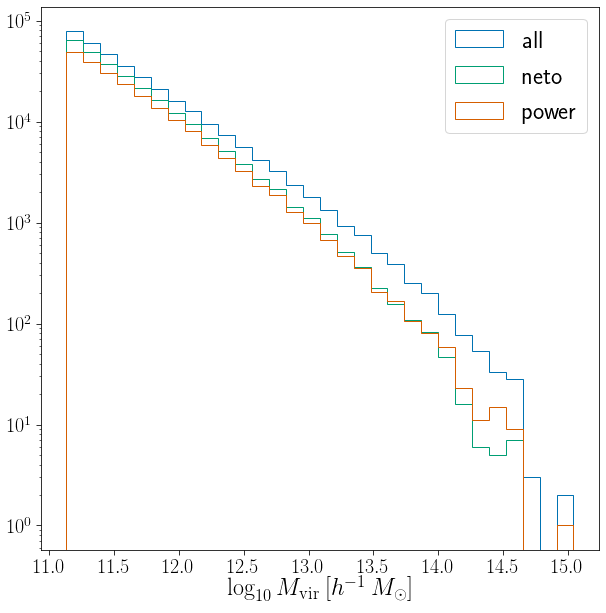

In [34]:
names = ['all', 'neto', 'power']
fig, ax = plt.subplots(1, 1)
n_bins = 30

all_mvirs = np.hstack([np.log10(dcats[name].cat['mvir']) for name in names])
bins = get_bins(all_mvirs, n_bins)


for i, name in enumerate(names):
    c = colors[i]
    legend_label = f'{name}'
    draw_histogram(ax, np.log10(dcats[name].cat['mvir']), bins=bins, color=c, legend_label=name, vline=None)
    
# fix axes and legend.
param_mvir = halo_parameters.get_hparam('mvir', log=True)
ax.set_xlabel(param_mvir.get_text())
plt.yscale('log')
ax.legend()
plt.show()

## Mean-centered and normalized log parameters

In [61]:
# maybe need to do a specific mass bin to have meaningful results here.
def make_mean_centered_histograms(n_bins=30):
    params = ["cvir", "eta", "x0", "v0", "spin", "q", "phi_l"]
    names = ['m11', 'm12', 'm13']
    fig, axes = plt.subplots(2, 4, figsize=(24, 16))
    normalize = lambda x: (x - np.mean(x)) / np.std(x)
    axes = axes.flatten()
    
    for i, (param, ax) in enumerate(zip(params, axes)):
        hparam = halo_parameters.get_hparam(param, log=True, modifiers=[normalize])
        xlabel = hparam.get_text()
        all_values = np.hstack([hparam.get_values(dcats[name].cat) for name in names])
        bins = get_bins(all_values, n_bins)
        for c, name in zip(colors, names):
            hcat = dcats[name]
            x = hparam.get_values(hcat.cat)
            draw_histogram(ax, x, bins=bins, vline='median', legend_label=name, color=c)
        ax.set_yscale('log')
        ax.set_xlabel(xlabel, size=30)
        
        if i==0:
            ax.legend()
    plt.tight_layout()

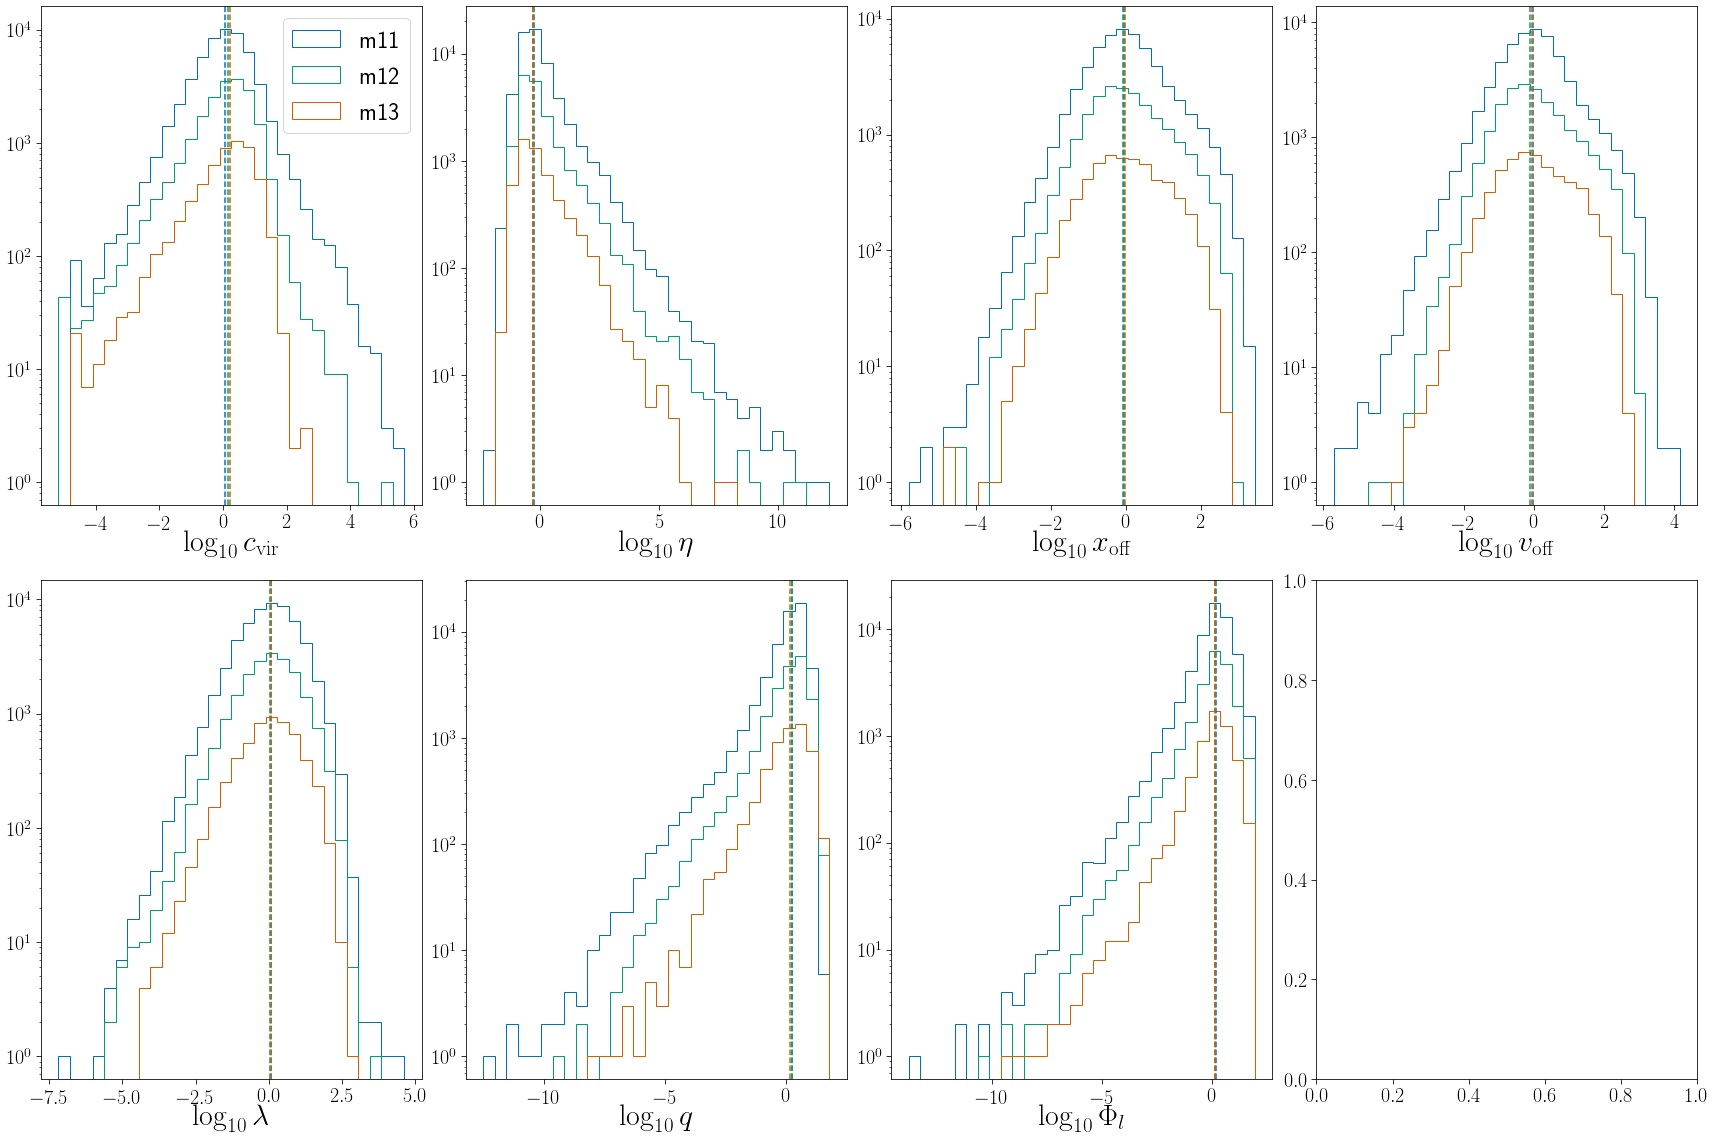

In [62]:
# TODO: add title -> all haloes for each of the samples, add legend to the first plot, add xlabel
make_mean_centered_histograms()

# Scatter binning

## Relaxed parameters as a function of mass bin

In [66]:
def make_scatter_binning(ax, x, y, n_xbins=30, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask]) > 0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    xdiffs = abs(x_bds.reshape(-1, 2) - xmeds.reshape(-1, 1))

    ax.errorbar(
        xmeds,
        ymeds,
        xerr=xdiffs.T,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

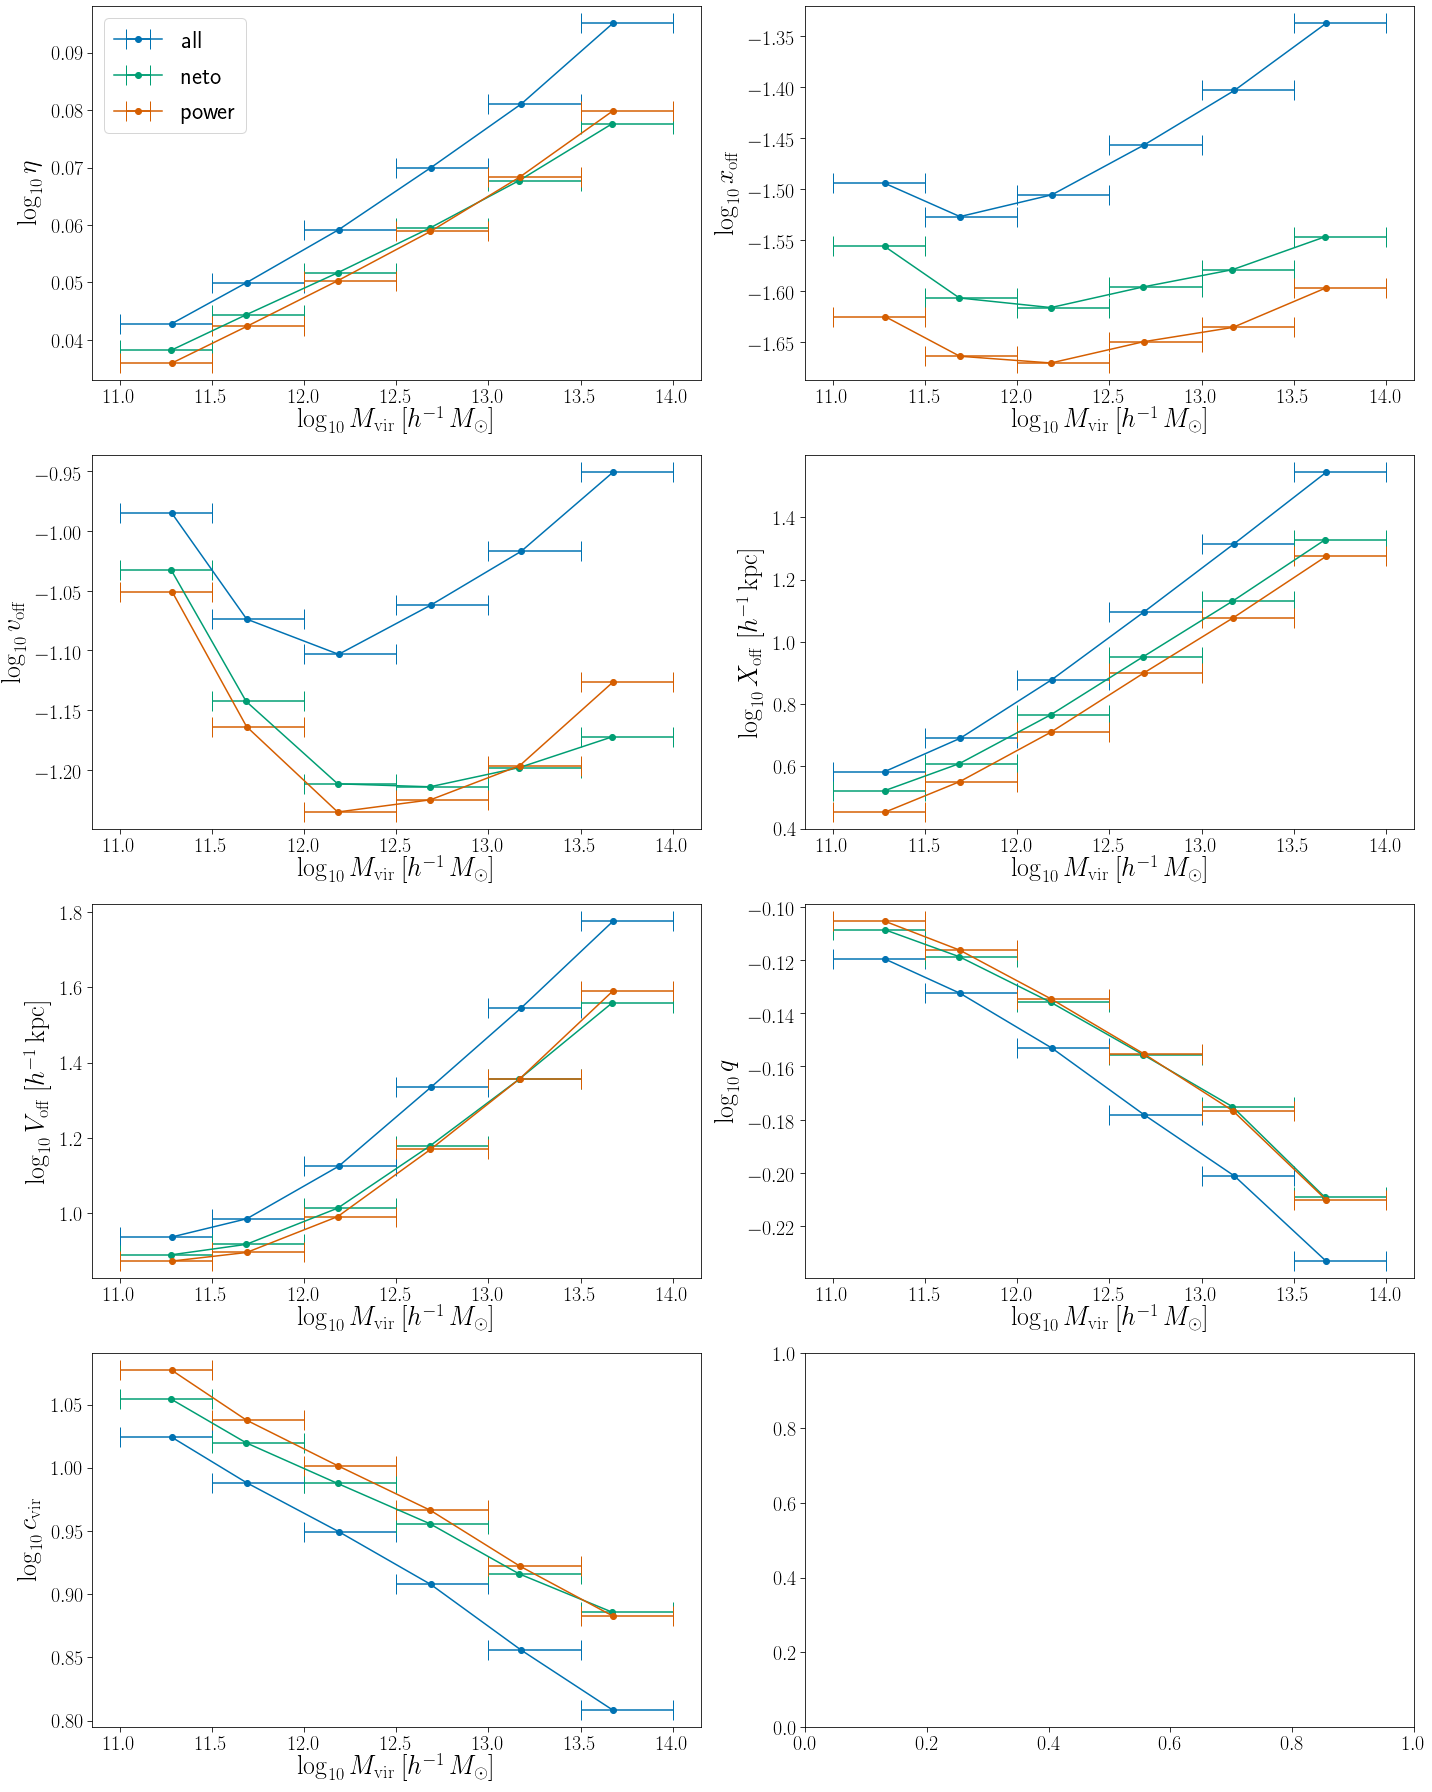

In [70]:
mass_bin_bds = np.arange(11, 14.5, 0.5)
names = ['all', 'neto', 'power']
params = ["eta", "x0", "v0", "xoff", "voff", "q", "cvir"]
hparams = {param: get_hparam(param, log=True) for param in params}
hparams['mvir'] = get_hparam('mvir', log=True)


fig, axes = plt.subplots(4, 2, figsize=(20, 25))
axes = axes.flatten()
for i, (ax, param) in enumerate(zip(axes, params)):
    for c, name in zip(colors, names):
        hcat = dcats[name]
        xlabel = hparams['mvir'].get_text()
        ylabel = hparams[param].get_text()
        x = hparams['mvir'].get_values(hcat.cat)
        y = hparams[param].get_values(hcat.cat)
        make_scatter_binning(ax, x, y, bin_bds=mass_bin_bds, show_bands=False, color=c, label=name)
        ax.set_xlabel(xlabel, size=26)
        ax.set_ylabel(ylabel, size=26)
    if i==0: 
        ax.legend()
plt.tight_layout()
plt.show()

## Correlations of pairs of relaxed parameters at fixed mass

In [158]:
# first create all pairs
names = ['m11', 'm12', 'm13']
params = ["t/|u|", "x0", "v0", "q", "cvir"]
hparams = {param: get_hparam(param, log=True) for param in params}
all_pairs = []
nums = [1, 2, 3, 4, 5, 6, 7, 9, 10, 13]
for i, param1 in enumerate(params):
    for j, param2 in enumerate(params):
        if param1!= param2 and (param1, param2) not in all_pairs and (param2, param1) not in all_pairs:
            all_pairs.append((param1, param2))
            pos[(param1, param2)] = nums.pop(0)


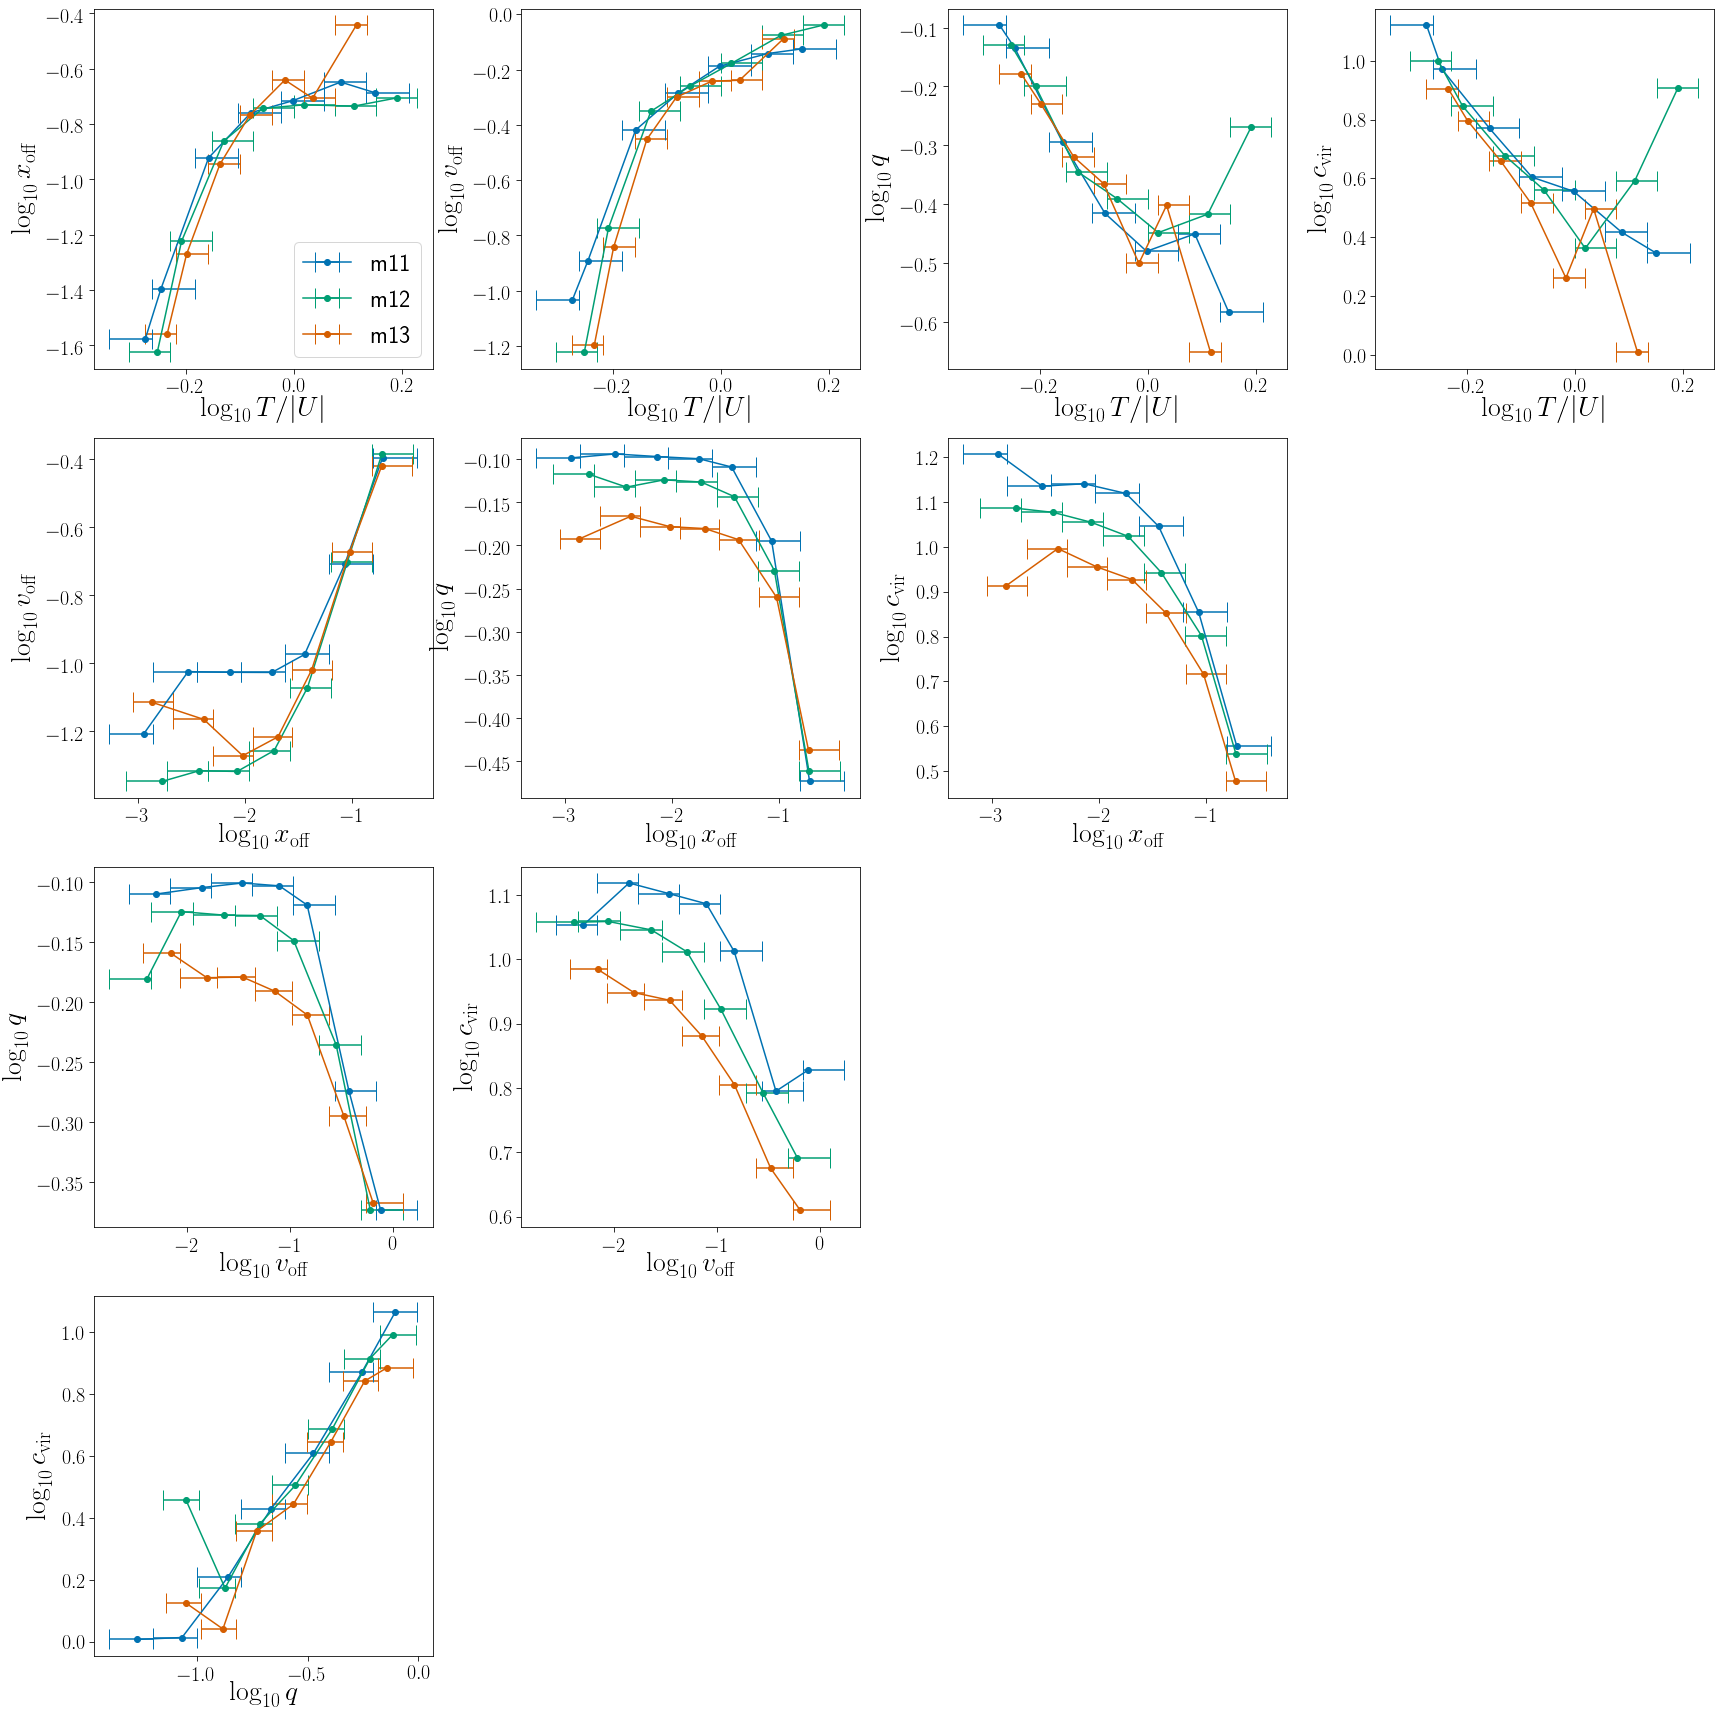

In [161]:
figsize = (24, 24)
fig = plt.figure(figsize=figsize)
for (param1, param2) in pos:
    i = pos[(param1, param2)]
    ax = fig.add_subplot(4, 4,  i)
    for c, name in zip(colors, names):
        x = hparams[param1].get_values(dcats[name].cat)
        y = hparams[param2].get_values(dcats[name].cat)
        xlabel = hparams[param1].get_text()
        ylabel = hparams[param2].get_text()
        make_scatter_binning(ax, x, y, n_xbins=8, bin_bds=None, show_bands=False, color=c, label=name)

        ax.set_xlabel(xlabel, size=28)
        ax.set_ylabel(ylabel, size=28)
        ax.tick_params(axis='both', which='major', labelsize=20)

    if i==1: 
        ax.legend(loc='best')
plt.tight_layout()
plt.show()

# Correlation Matrix 

In [113]:
from scipy.stats import spearmanr

def plot_correlation_matrix(ax, values, cell_text_size=14):
    # values: list of values of ech para
    n_params = len(values)
    matrix = np.zeros((n_params, n_params))

    for i, value1 in enumerate(values):
        for j, value2 in enumerate(values):
            matrix[i, j] = spearmanr(value1, value2)[0]

    # mask out lower off-diagonal elements if requested.
    im = ax.matshow(matrix, cmap="bwr", vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)

    # add the values to each cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            _ = ax.text(
                j,
                i,
                round(matrix[i, j], 2),
                ha="center",
                va="center",
                color="k",
                size=cell_text_size,
            )

<Figure size 720x720 with 0 Axes>

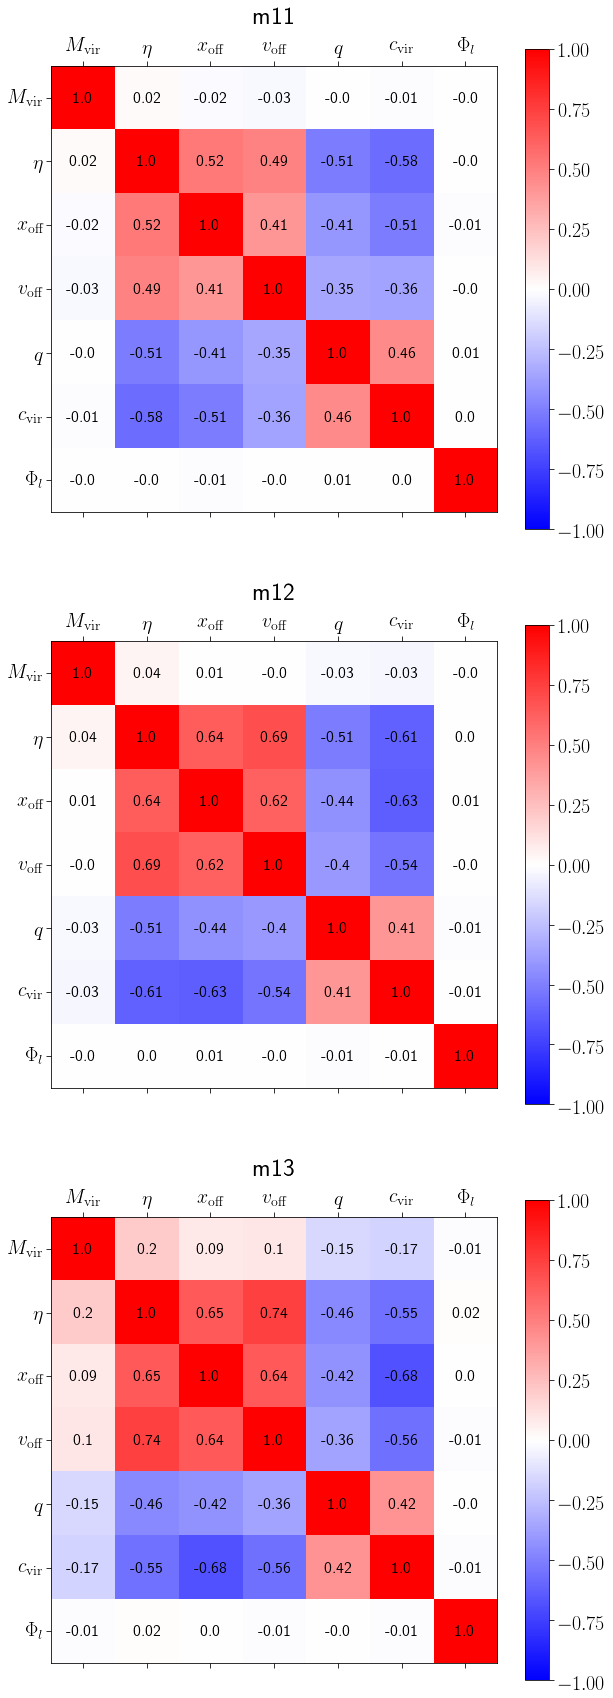

In [115]:
params = ["mvir", "eta", "x0", "v0", "q", "cvir", "phi_l"]
hparams = {param: get_hparam(param, log=True) for param in params}
names = ['m11', 'm12', 'm13']

fig, axes = plt.subplots(3, 1, figsize=(10, 30))

for ax, name in zip(axes, names):
    latex_params = [
        hparams[param].get_text(only_param=True)
        for param in params
    ]
    values = [
        hparams[param].get_values(dcats[name].cat)
        for param in params
    ]
    
    plot_correlation_matrix(ax, values, cell_text_size=16)
    
    ax.set_xticks(range(len(latex_params)))
    ax.set_xticklabels(latex_params, size=20)

    ax.set_yticks(range(len(latex_params)))
    ax.set_yticklabels(latex_params, size=20)
    
    ax.set_title(name, size=25, pad=20)
    
plt.show()
plt.tight_layout()
